![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+GenAI%2FChunking&file=Process+Documents+-+Document+AI+Layout+Parser.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Chunking/Process%20Documents%20-%20Document%20AI%20Layout%20Parser.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520GenAI%2FChunking%2FProcess%2520Documents%2520-%2520Document%2520AI%2520Layout%2520Parser.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Chunking/Process%20Documents%20-%20Document%20AI%20Layout%20Parser.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20GenAI/Chunking/Process%20Documents%20-%20Document%20AI%20Layout%20Parser.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Process Documents With The Document AI Layout Parser

This workflow creates chunks from documents to be used in embeddings workflow examples in [this series](./Embeddings/readme.md) as well as throughout the [Applied GenAI](../readme.md) series. This workflow will give examples for:
- This document:[Official Rules of Baseball](https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf)
- Processed and chunked using the [Layout Parser from Document AI](https://cloud.google.com/document-ai/docs/layout-parse-chunk)
- And results are stored in a local folder(`./example-data/chunks.jsonl`) in this repository

**Document AI** Workflow
<p align="center" width="100%"><center>
    <img src="../../architectures/architectures/images/working with/documentai/readme/high_level.png">
</center></p>

This workflow shows how to use the processor named **Layout Parser** to:
- Process Documents
    - Online request
    - Batch request
- Parse Responses
    - paragraphs
    - tables
    - titles
    - headings
    - page header
    - page footer
    - chunks

Learn more about Document AI and the wide variety of parsers as well as methods for working with the responses in this series: [Working With Document AI](../../Working%20With/Document%20AI/readme.md)

---
## Colab Setup

When running this notebook in [Colab](https://colab.google/) or [Colab Enterprise](https://cloud.google.com/colab/docs/introduction), this section will authenticate to GCP (follow prompts in the popup) and set the current project for the session.

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [22]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.documentai', 'google-cloud-documentai', '2.31.0'),
    ('google.cloud.storage', 'google-cloud-storage'),
    ('fitz', 'pymupdf'),
    ('PIL', 'Pillow')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [5]:
!gcloud services enable documentai.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [6]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

Inputs

In [7]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [53]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'layout-parser'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

Packages

In [54]:
import os
import re
import IPython.display
import io
import json
import base64
import requests
import concurrent.futures
import asyncio
import fitz #pymupdf
import PIL.Image

from google.cloud import documentai
from google.cloud import storage

Clients

In [224]:
# document AI client
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)
docai_async_client = documentai.DocumentProcessorServiceAsyncClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

Parameters:

In [56]:
DIR = f"{EXPERIMENT}"

Environment:

In [57]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Document

The [official rules of baseball](https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf), a pdf that is updated annually with the latest changes to the game and published by MLB.


### Load The Document

In [202]:
url = 'https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf'

In [203]:
response = requests.get(url).content
document = fitz.open(stream = response, filetype = "pdf")

In [204]:
document.page_count

192

### Get Text From First Page

In [205]:
page = document.load_page(0)
page.get_text()

'OFFICIAL BASEBALL RULES\n2023 Edition\n'

### View First Page

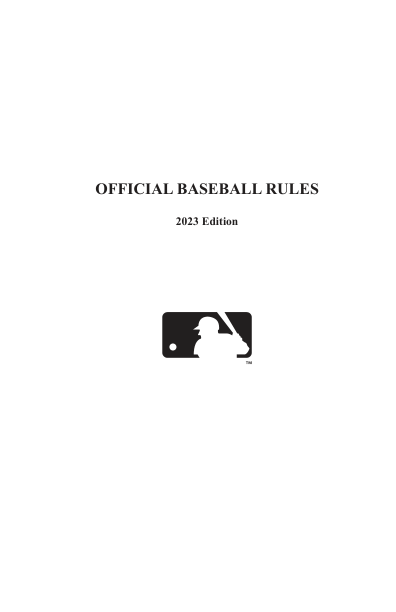

In [206]:
pix = page.get_pixmap()
image = PIL.Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
IPython.display.display(image)

### Create New PDF with First 5 pages

In [207]:
small_document = fitz.open()
small_document.insert_pdf(document, from_page=0, to_page=4)

In [208]:
small_document.page_count

5

### Documents As Byte Strings

In [209]:
buffer = io.BytesIO()
document.save(buffer)
document_bytes = base64.b64encode(buffer.getvalue()).decode('utf-8')

buffer = io.BytesIO()
small_document.save(buffer)
small_document_bytes = base64.b64encode(buffer.getvalue()).decode('utf-8')

### Documents As Local Files

In [210]:
document.save(f"{DIR}/document.pdf")
small_document.save(f"{DIR}/small_document.pdf")

In [211]:
os.listdir(DIR)

['small_document.pdf', 'document.pdf']

### Documents As GCS Files

In [212]:
blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files/document.pdf')
blob.upload_from_string(base64.b64decode(document_bytes), content_type = 'application/pdf')

In [213]:
blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files/small_document.pdf')
blob.upload_from_string(base64.b64decode(small_document_bytes), content_type = 'application/pdf')

In [214]:
list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files'))

[<Blob: statmike-mlops-349915, applied-genai/layout-parser/files/document.pdf, 1726672977725587>,
 <Blob: statmike-mlops-349915, applied-genai/layout-parser/files/small_document.pdf, 1726672977953232>]

---
## Layout Parser

Document AI is comprised of multiple processors.  In this case the [Layout Parser](https://cloud.google.com/document-ai/docs/layout-parse-chunk) is used for its ability to detect and extract paragraphs, tables, titles, heading, page headers, and page footers.  

For a more thorough review of Document AI processors, including customized parsers, see the [Working With/Document AI](../../Working%20With/Document%20AI/readme.md) section of this repository.  This repository includes examples of processing documents at larger scales and storing the data for processing and retrieval.

### Get/Create Processor: Layout Parser

In [48]:
PARSER_DISPLAY_NAME = 'my_layout_processor'
PARSER_TYPE = 'LAYOUT_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-layout-parser-v1.0-2024-06-03'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
    if p.display_name == PARSER_DISPLAY_NAME:
        parser = p
try:
    print('Retrieved existing parser: ', parser.name)
except Exception:
    parser = docai_client.create_processor(
        parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
        processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
    )
    print('Created New Parser: ', parser.name)

Retrieved existing parser:  projects/1026793852137/locations/us/processors/3779bd3a8f535977


---
## Process Document - Multiple Ways

The [Layout Parser](https://cloud.google.com/document-ai/docs/layout-parse-chunk) can process different files types:
- HTML
- PDF
- DOCX
- PPTX
- XLSX/XLSM

There are limitations for processing based on the online versus the batch clients:
- Online: 20MB per file and up to 15 pages
- Batch: 40MB per file and up to 500 pages, but multiple files (up to 5,000 per request)

The parsed content from this parser will contain:
- paragraphs
- tables
- titles
- headings
- page header
- page footer
- chunks

The clients have default [quotas](https://cloud.google.com/document-ai/quotas) and [limits](https://cloud.google.com/document-ai/limits):
- 1800 request per user per minute per project
    - online:
        - 600 per project
        - 120 per processor type
    - batch (concurrent):
        - 10 per project
        - 5 per processor
- see the links for more details


The code below shows multiple ways to process documents both online and batch:
- Online:
    - document inline (bytes)
    - Raw document (local folder)
    - GCS document (GCS)
- Online Async with multiple request of the same document, for different page ranges
- Batch: documents in GCS
    - Multiple document

### Online Processing: Inline Document

Reference:
- [documentai.ProcessRequest()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessRequest)
    - `inline_document` = [documentai.Document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)
    - `process_options` = [documentai.ProcessOptions()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions)
        - `layout_config` = [documentai.ProcessOptions.LayoutConfig()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions.LayoutConfig)

In [171]:
online_inline_response = docai_client.process_document(
    request = documentai.ProcessRequest(
        name = parser.name,
        inline_document = documentai.Document(
            content = small_document_bytes,
            mime_type = 'application/pdf'
        ),
        process_options = documentai.ProcessOptions(
            from_start = 5,
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        ),
    )
)

#### Review response for `document_layout.blocks`:

- The document is parsed into a block structure based on headings

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [172]:
online_inline_response.document.document_layout.blocks[0].text_block.text

'OFFICIAL BASEBALL RULES'

#### Review response for `chunked_document.chunks`:

- number of chunks and the first chunk

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [173]:
len(online_inline_response.document.chunked_document.chunks)

11

In [174]:
online_inline_response.document.chunked_document.chunks[0]

chunk_id: "c1"
content: "# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM"
page_span {
  page_start: 1
  page_end: 2
}

### Online Processing: Raw Document

Reference:
- [documentai.ProcessRequest()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessRequest)
    - `raw_document` = [documentai.RawDocument()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.RawDocument)
    - `process_options` = [documentai.ProcessOptions()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions)
        - `layout_config` = [documentai.ProcessOptions.LayoutConfig()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions.LayoutConfig)

In [175]:
online_raw_response = docai_client.process_document(
    request = documentai.ProcessRequest(
        name = parser.name,
        raw_document = documentai.RawDocument(
            content = small_document_bytes,
            mime_type = 'application/pdf'
        ),
        process_options = documentai.ProcessOptions(
            from_start = 5,
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        )
    )
)

#### Review response for `document_layout.blocks`:

- The document is parsed into a block structure based on headings

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [176]:
online_raw_response.document.document_layout.blocks[0].text_block.text

'OFFICIAL BASEBALL RULES'

#### Review response for `chunked_document.chunks`:

- number of chunks and the first chunk

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [177]:
len(online_raw_response.document.chunked_document.chunks)

11

In [178]:
online_raw_response.document.chunked_document.chunks[0]

chunk_id: "c1"
content: "# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM"
page_span {
  page_start: 1
  page_end: 2
}

### Online Processing: GCS Document

Reference:
- [documentai.ProcessRequest()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessRequest)
    - `gcs_document` = [documentai.GcsDocument()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.GcsDocument)
    - `process_options` = [documentai.ProcessOptions()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions)
        - `layout_config` = [documentai.ProcessOptions.LayoutConfig()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions.LayoutConfig)

In [179]:
online_gcs_response = docai_client.process_document(
    request = documentai.ProcessRequest(
        name = parser.name,
        gcs_document = documentai.GcsDocument(
            gcs_uri = f'gs://{bucket.name}/{SERIES}/{EXPERIMENT}/files/small_document.pdf',
            mime_type = 'application/pdf'
        ),
        process_options = documentai.ProcessOptions(
            from_start = 5,
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        )
    )
)

#### Review response for `document_layout.blocks`:

- The document is parsed into a block structure based on headings

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [180]:
online_gcs_response.document.document_layout.blocks[0].text_block.text

'OFFICIAL BASEBALL RULES'

#### Review response for `chunked_document.chunks`:

- number of chunks and the first chunk

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [181]:
len(online_gcs_response.document.chunked_document.chunks)

11

In [182]:
online_gcs_response.document.chunked_document.chunks[0]

chunk_id: "c1"
content: "# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM"
page_span {
  page_start: 1
  page_end: 2
}

### Batch Processing: Multiple Documents and/or Larger Documents

With batch processing there are two ways to specify documents.  A list of documents with uris or a prefix for the uri to match.  Either of these would work for the `input_documents` parameter of batch processing here:

**List Each Document**
```
        input_documents = documentai.BatchDocumentsInputConfig(
            gcs_documents = documentai.GcsDocuments(
                documents = [
                    
                    documentai.GcsDocument(
                        gcs_uri = f'gs://{bucket.name}/{SERIES}/{EXPERIMENT}/files/document.pdf',
                        mime_type = 'application/pdf'
                    ),
                    documentai.GcsDocument(
                        gcs_uri = f'gs://{bucket.name}/{SERIES}/{EXPERIMENT}/files/small_document.pdf',
                        mime_type = 'application/pdf'
                    )
                ]
            )
        )
```
**Common Prefix For Documents**
```
        input_documents = documentai.BatchDocumentsInputConfig(
            gcs_prefix = documentai.GcsPrefix(
                gcs_uri_prefix = f'gs://{bucket.name}/{SERIES}/{EXPERIMENT}/files'
            )
        )
```

Reference:
- [google.cloud.documentai.DocumentProcessorServiceClient.batch_process_documents()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_batch_process_documents)

In [215]:
batch_job = docai_client.batch_process_documents(
    request = documentai.BatchProcessRequest(
        name = parser.name,
        input_documents = documentai.BatchDocumentsInputConfig(
            gcs_prefix = documentai.GcsPrefix(
                gcs_uri_prefix = f'gs://{bucket.name}/{SERIES}/{EXPERIMENT}/files/'
            )
        ),
        document_output_config = documentai.DocumentOutputConfig(
            gcs_output_config = documentai.DocumentOutputConfig.GcsOutputConfig(
                gcs_uri = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/parsing'
            )
        ),
        process_options = documentai.ProcessOptions(
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        )
    )
)

print(f'Waiting on batch job to complete: {batch_job.operation.name}')
batch_job.result()

print(documentai.BatchProcessMetadata(batch_job.metadata).state)

Waiting on batch job to complete: projects/1026793852137/locations/us/operations/4246794143789906350
State.SUCCEEDED


#### Retrieve Document Parsing Results

In [216]:
batch_responses = []
for process in documentai.BatchProcessMetadata(batch_job.metadata).individual_process_statuses:
    matches = re.match(r"gs://(.*?)/(.*)", process.output_gcs_destination)
    output_bucket, output_prefix = matches.groups()
    output_blobs = bucket.list_blobs(prefix = output_prefix)
    for blob in output_blobs:
        response = documentai.Document.from_json(blob.download_as_bytes(), ignore_unknown_fields = True)
        batch_responses.append((blob.name.split('/')[-1], response))

In [217]:
len(batch_responses)

2

#### Review response for a document:

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [218]:
batch_responses[0][0], batch_responses[1][0]

('document-0.json', 'small_document-0.json')

In [219]:
batch_responses[0][1].chunked_document.chunks[0]

chunk_id: "c1"
content: "# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM"
page_span {
  page_start: 1
  page_end: 7
}
page_footers {
  text: "V1"
  page_span {
    page_start: 6
    page_end: 6
  }
}
page_footers {
  text: "vii"
  page_span {
    page_start: 7
    page_end: 7
  }
}

In [220]:
batch_responses[1][1].chunked_document.chunks[0]

chunk_id: "c1"
content: "# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM"
page_span {
  page_start: 1
  page_end: 2
}

### Online Async Processing: Multiple Parallel Requests For Different Pages

The online request are limited in file size and number of pages.  In this case, the layout parser, the limit is 15 pages for online and 500 for batch. 

There are ways to work with document segments with the online client and this enables processing of larger content.  Additionally, the async client for Document AI makes it possible to handle multiple simoultaneous request from a single client session.

The example below shows using these techniques to process the entire 192 page document with online processing.

Reference:
- [documentai.ProcessRequest()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessRequest)
    - `inline_document` = [documentai.Document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)
    - `process_options` = [documentai.ProcessOptions()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions)
        - `individual_page_selector` = [documenai.ProcessOptions.IndividualPageSelector](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions.IndividualPageSelector)
        - `layout_config` = [documentai.ProcessOptions.LayoutConfig()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions.LayoutConfig)

#### Determine The Number of Document Segments

A single request for online processing can handle 15 pages.  Determine the number of 15 page segments with a little math:
- how many full 15 page segments: `document.page_count // 15`
- is there a partial segment at the end?: `1 * min(1, document.page_count % 15)`
- add these together

In [222]:
document.page_count

192

In [223]:
num_segments = document.page_count // 15 + 1 * min(1, document.page_count % 15)
num_segments

13

In [226]:
page_segments = []
for segment in range(num_segments):
    page_segments.append(
        [i+1 for i in range(15*segment, min(document.page_count, 15*(segment + 1)))]
    )

In [233]:
print(
    'Number of segments: ', len(page_segments),
    '\nPages in first segment: ', page_segments[0],
    '\nPages in last segment: ', page_segments[-1]
)

Number of segments:  13 
Pages in first segment:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 
Pages in last segment:  [181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192]


#### Async Requests For Each Segment:

In [229]:
online_async_responses = await asyncio.gather(
    *[
        docai_async_client.process_document(
            request = documentai.ProcessRequest(
                name = parser.name,
                inline_document = documentai.Document(
                    content = document_bytes,
                    mime_type = 'application/pdf'
                ),
                process_options = documentai.ProcessOptions(
                    individual_page_selector = documentai.ProcessOptions.IndividualPageSelector(
                        pages = segment
                    ),
                    layout_config = documentai.ProcessOptions.LayoutConfig(
                        chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                            chunk_size = 100,
                            include_ancestor_headings = True,
                        )
                    )
                ),
            )
        ) for segment in page_segments
    ]
)

#### Review response for each segment:

How many chunks were created for each segment?

In [235]:
for response in online_async_responses:
    print(len(response.document.chunked_document.chunks))

867
867
867
867
867
867
867
867
867
867
867
867
867


**Note to check:** It appears the full document is being processe rather than the page range even though it exceed the 15 page max

---
## Process Responses


---
---
---
---
---
## Process Document

Document AI has online and batch processing.  These methods are subject to [limits](https://cloud.google.com/document-ai/limits#content_limits) and [qoutas](https://cloud.google.com/document-ai/quotas).  In this case online is limited to 15 pages and batch is limited to 500 pages.  The document is >100 pages so we either have to split it into smaller sections, like pages, for online processing or use batch processing.  Batch processing works for documents stored in GCS.

> NOTE: The code below could be extended to many document in many locations.

### Move Document To GCS

In [16]:
blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/mlb_rules.pdf')
blob.upload_from_string(context_bytes, content_type = 'application/pdf')

### Batch Process Document

In [17]:
from google.api_core.exceptions import InternalServerError
from google.api_core.exceptions import RetryError

batch_job = docai_client.batch_process_documents(
    request = documentai.BatchProcessRequest(
        name = parser.name,
        input_documents = documentai.BatchDocumentsInputConfig(
            gcs_documents = documentai.GcsDocuments(
                documents = [
                        documentai.GcsDocument(
                            gcs_uri = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/mlb_rules.pdf',
                            mime_type = 'application/pdf'
                    )
                ]
            )
        ),
        document_output_config = documentai.DocumentOutputConfig(
            gcs_output_config = documentai.DocumentOutputConfig.GcsOutputConfig(
                gcs_uri = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/parsing'
            )
        ),
        process_options = documentai.ProcessOptions(
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        )
    )
)
print(f'Waiting on batch job to complete: {batch_job.operation.name}')
batch_job.result()
        
print(documentai.BatchProcessMetadata(batch_job.metadata).state)

Waiting on batch job to complete: projects/1026793852137/locations/us/operations/6654363295788003058
State.SUCCEEDED


### Retrieve Document Parsing Results

In [18]:
documents = []
for process in documentai.BatchProcessMetadata(batch_job.metadata).individual_process_statuses:
    matches = re.match(r"gs://(.*?)/(.*)", process.output_gcs_destination)
    output_bucket, output_prefix = matches.groups()
    output_blobs = bucket.list_blobs(prefix = output_prefix)
    for blob in output_blobs:
        document = documentai.Document.from_json(blob.download_as_bytes(), ignore_unknown_fields = True)
        documents.append(document)

In [19]:
len(documents)

1

In [20]:
parsed_document = documentai.Document.to_dict(documents[0])

In [21]:
parsed_document.keys()

dict_keys(['shard_info', 'document_layout', 'chunked_document', 'mime_type', 'text', 'text_styles', 'pages', 'entities', 'entity_relations', 'text_changes', 'revisions'])

In [22]:
parsed_document['chunked_document'].keys()

dict_keys(['chunks'])

### Parse Chunks

Create a list of dictionaries for each chunk

In [23]:
len(parsed_document['chunked_document']['chunks'])

867

In [24]:
parsed_document['chunked_document']['chunks'][0].keys()

dict_keys(['chunk_id', 'content', 'page_span', 'page_footers', 'source_block_ids', 'page_headers'])

In [25]:
parsed_document['chunked_document']['chunks'][0]

{'chunk_id': 'c1',
 'content': '# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM',
 'page_span': {'page_start': 1, 'page_end': 7},
 'page_footers': [{'text': 'V1',
   'page_span': {'page_start': 6, 'page_end': 6}},
  {'text': 'vii', 'page_span': {'page_start': 7, 'page_end': 7}}],
 'source_block_ids': [],
 'page_headers': []}

In [26]:
chunks = [
    dict(
        chunk_id = chunk['chunk_id'],
        content = chunk['content'],
    ) for chunk in parsed_document['chunked_document']['chunks']
]

In [27]:
chunks[0]

{'chunk_id': 'c1',
 'content': '# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM'}